
## Projet : Optimisation de Tournées de Livraison pour l'ADEME

# Livrable final 

**Groupe** : Groupe 2

**Membres** :
- ABDELKKADERMEKKI Mohamed 
- BENAZIZ Rayan
- HALLAOUA Sid-Ali
- RECHAM Wissam


---

## Table des Matières

1. [Rappel du Contexte et des Objectifs](#1-Rappel-du-Contexte-et-des-Objectifs)

2. [Modélisation Mathématique Formelle](#3-modélisation-mathématique-formelle)

3. [Méthode de Résolution Choisie](#4-Méthode-de-Résolution-Choisie)

4. [Implémentation](#4-Implémentation)

5. [Etude expérimentale](#5-Etude-expérimentale)

6. [Conclusion](#6-conclusion)



---

# Rappel du Contexte et des Objectifs

Dans le cadre de l’appel à manifestation d’intérêt lancé par l’ADEME, l’objectif général est de proposer des solutions innovantes permettant d’optimiser la mobilité et la logistique dans différents types de territoires.
Les enjeux actuels de mobilité — hausse de la demande de livraison, contraintes environnementales, variabilité du trafic, optimisation des ressources — rendent indispensable l’utilisation de méthodes de Recherche Opérationnelle pour améliorer l’efficacité des tournées de transport.

Notre équipe a choisi de se concentrer sur l’optimisation des tournées de livraison, un problème central en logistique.
Dans ce contexte, nous étudions une variante avancée du problème classique de tournées : le Vehicle Routing Problem with Time Windows (VRPTW).

Le VRPTW consiste à déterminer un ensemble de tournées permettant de desservir un ensemble de clients à partir d’un dépôt unique, en minimisant le coût total (généralement la distance ou la durée) tout en respectant des fenêtres temporelles strictes.
Chaque client doit être servi dans un créneau précis, ce qui rend le problème sensiblement plus complexe que le VRP classique.

Ce projet poursuit trois objectifs principaux :
 1. Proposer un modèle formel robuste.
 2. Concevoir et implémenter un algorithme performant.
 3. Évaluer expérimentalement les performances.

# Modèle Mathématique

## 1. Présentation du Problème

Le **VRPTW** (Vehicle Routing Problem with Time Windows) est un problème d'optimisation combinatoire consistant à déterminer un ensemble de tournées de véhicules pour desservir des clients, en minimisant le coût total tout en respectant : Les **fenêtres temporelles** de livraison de chaque client

## 2. Représentation par Graphe

Le problème est modélisé sur un **graphe complet orienté** : $G = (V, A)$

### Ensemble des nœuds
$$V = \{0, 1, 2, ..., n\}$$

Où :
- $0$ : Le **dépôt** (point de départ et d'arrivée de tous les véhicules)
- $i \in \{1, ..., n\}$ : Les $n$ **clients** à desservir

### Ensemble des arcs
$$A = \{(i,j) : i, j \in V, i \neq j\}$$

Chaque arc $(i,j)$ représente un trajet possible du nœud $i$ vers le nœud $j$.

**Propriétés :**
- Graphe **complet** : il existe un arc entre chaque paire de nœuds
- Graphe **orienté** : nécessaire pour la modélisation des contraintes temporelles
- Graphe **pondéré** : chaque arc a un poids $d_{ij}$ (distance ou temps)


## 3. Paramètres du Problème

<u>3.1 Paramètres géographiques</u>

| Notation | Description | Type |
|----------|-------------|------|
| $n$ | Nombre de clients à desservir | Entier |
| $d_{ij}$ | Temps de trajet entre les nœuds $i$ et $j$ | Réel $\geq 0$ |

**Propriétés de la matrice de temps :**
- $d_{ii} = 0$ pour tout $i$ (temps nul d'un point vers lui-même)
- Symétrie (distances euclidiennes) : $d_{ij} = d_{ji}$
- Inégalité triangulaire : $d_{ij} \leq d_{ik} + d_{kj}$, $\forall i,j,k \in V$

<u>3.2 Paramètres des clients</u>

Pour chaque client $i \in V$ :

| Notation | Description | Unité |
|----------|-------------|-------|
| $q_i$ | Demande du client $i$ (quantité à livrer) | kg, unités |
| $s_i$ | Temps de service au client $i$ | minutes |
| $a_i$ | Début de la fenêtre temporelle (earliest time) | minutes |
| $b_i$ | Fin de la fenêtre temporelle (latest time) | minutes |

**Convention pour le dépôt** (nœud 0) :
- $q_0 = 0$ (pas de demande)
- $s_0 = 0$ (pas de temps de service)
- $[a_0, b_0]$ : Horaires d'ouverture du dépôt

<u>3.3 Paramètres des véhicules</u>

| Notation | Description | Type |
|----------|-------------|------|
| $K$ | Nombre de véhicules disponibles | Entier |
| $Q$ | Capacité maximale d'un véhicule | kg, unités |

**Hypothèses :**
- Flotte **homogène** : tous les véhicules ont la même capacité $Q$
- Dépôt **unique** : tous les véhicules partent du même point
- Nombre de véhicules **suffisant** pour desservir tous les clients


## 4. Variables de Décision

<u>4.1 Formulation exacte (programmation linéaire)</u>

**Variables binaires de routage :**
$$x_{ijk} \in \{0, 1\}, \quad \forall (i,j) \in A, \forall k \in K$$

Définition :
$$x_{ijk} = \begin{cases} 
1 & \text{si le véhicule } k \text{ emprunte l'arc } (i,j) \\
0 & \text{sinon}
\end{cases}$$

**Variables temporelles :**
$$t_i \in \mathbb{R}^+, \quad \forall i \in V$$

Où $t_i$ représente le **temps d'arrivée** (ou début de service) au nœud $i$.

**Variables auxiliaires (MTZ) :**
$$u_i \in \mathbb{N}, \quad 1 \leq u_i \leq n, \quad \forall i \in V \setminus \{0\}$$

Où $u_i$ représente la position du client $i$ dans sa tournée (pour éliminer les sous-tournées).

<u>4.2 Représentation heuristique</u>

Dans notre approche **métaheuristique ALNS**, la solution est représentée par une **structure de données par chemins** :

```python
routes: List[List[int]]  # Liste de routes (tournées)
```

**Exemple :**
```python
routes = [[1, 5, 3], [2, 7, 9], [4, 6, 8]]
```
- Route 1 : Dépôt → Client 1 → Client 5 → Client 3 → Dépôt
- Route 2 : Dépôt → Client 2 → Client 7 → Client 9 → Dépôt
- Route 3 : Dépôt → Client 4 → Client 6 → Client 8 → Dépôt

Cette représentation est **mathématiquement équivalente** aux variables $x_{ijk}$ mais plus adaptée aux algorithmes heuristiques.


## 5. Fonction Objectif

<u>5.1 Formulation exacte</u>

**Minimiser le temps total de parcours** (makespan - temps du dernier camion à terminer sa tournée) :

$$\min Z = \sum_{k \in K} \sum_{i \in V} \sum_{j \in V, j \neq i} d_{ij} \cdot x_{ijk}$$

Où $d_{ij}$ représente le **temps de trajet** entre les nœuds $i$ et $j$.

###  Contraintes de base

Les contraintes principales du CVRP sont :

1. **Chaque client est servi une seule fois :**  

$$
\sum_{k \in K} \sum_{j \in V} x_{ijk} = 1 \quad \forall i \in \{1, \dots, n\}
$$

2. **Conservation de flux pour chaque véhicule :**  

$$
\sum_{j \in V} x_{ijk} = \sum_{j \in V} x_{jik}
\quad \forall i \in V, \forall k \in K
$$

3. **Capacité des véhicules :**  

$$
\sum_{i \in V} d_i \sum_{j \in V} x_{ijk} \le Q_k, \quad \forall k \in K
$$

4. **Départ et retour au dépôt :**  

$$
\sum_{j \in V} x_{0jk} = 1, \quad
\sum_{i \in V} x_{i0k} = 1, \quad \forall k \in K
$$



<u>5.2 Formulation heuristique avec pénalisation (implémentation ALNS)</u>

Notre approche transforme les **contraintes dures en contraintes souples** via une fonction de pénalisation :

$$\min Z = D + \lambda_C \cdot V_C + \lambda_T \cdot V_T$$
- $D$ = Temps total de parcours de toutes les tournées
Où :
- $D$ = Distance totale réelle des tournées
- $V_C$ = Violations de **capacité** (dépassements cumulés)
- $V_T$ = Violations de **fenêtres temporelles** (retards cumulés)
- $\lambda_C, \lambda_T$ = Coefficients de pénalité (typiquement $= 10000$)

**Temps total de parcours :**

**Distance totale :**
$$D = \sum_{r \in \text{routes}} \left( d_{0,r_1} + \sum_{i=1}^{|r|-1} d_{r_i, r_{i+1}} + d_{r_{|r|}, 0} \right)$$

**Violations de capacité :**
$$V_C = \sum_{r \in \text{routes}} \max\left(0, \sum_{i \in r} q_i - Q\right)$$

**Violations temporelles :**
$$V_T = \sum_{i=1}^{n} \max(0, t_i - b_i)$$

**Justification :** Cette approche permet aux métaheuristiques d'explorer temporairement des solutions non-faisables, facilitant l'échappement des minima locaux et la convergence vers de bonnes solutions.

## 6. Contraintes supplémentaires 

**Fenêtres temporelles (VRPTW)**  
Pour chaque client $i$, on impose :

$$
e_i \le t_i \le l_i
$$

avec possibilité d'arriver en avance et d'attendre jusqu'à $e_i$. L'heure de début de service est :

$$
t_i^{\text{service}} = \max(t_i, e_i)
$$

Dans notre solveur, cette contrainte est gérée via la fonction de coût :

- si $t_i > l_i$, une pénalité $\lambda (t_i - l_i)$ est ajoutée,
- un rapport par client (heure d'arrivée, respect ou non de la fenêtre) est conservé.

**Flotte de véhicules**  
Les véhicules sont supposés homogènes (même capacité). Chaque route correspond à un véhicule potentiel.




<u>6.4 Contraintes de fenêtres temporelles</u>

**Respect des fenêtres temporelles :**
$$a_i \leq t_i \leq b_i, \quad \forall i \in V$$

**Cohérence temporelle (contrainte Big-M) :**
$$t_j \geq t_i + s_i + d_{ij} - M(1 - x_{ijk}), \quad \forall i, j \in V, \forall k \in K$$

Où $M$ est une constante suffisamment grande. Cette contrainte assure que si un véhicule se déplace de $i$ vers $j$ :
$$t_j \geq t_i + s_i + d_{ij}$$

**Contrainte stricte (pas d'attente) :**

Le véhicule doit arriver exactement dans la fenêtre temporelle, sans possibilité d'attendre :
$$a_i \leq t_i \leq b_i$$

Le temps d'arrivée au client suivant est :
$$t_{i+1} = t_i + s_i + d_{i,i+1}$$



## 7. Complexité

<u>7.1 Complexité du problème</u>

Le CVRPTW est **NP-difficile** :
- Réduction depuis le TSP (NP-complet)
- Espace de recherche : $O((n!)^K)$ solutions possibles

<u>7.2 Complexité algorithmique</u>

**ALNS (par itération) :**
- Destruction : $O(n)$
- Réparation : $O(n^2)$ (test de toutes les positions)
- **Complexité par itération : $O(n^2)$**


# Méthode de Résolution Choisie
Dans le cadre de la résolution du VRPTW, un problème NP-difficile encore plus complexe que le VRP classique à cause des fenêtres temporelles, le choix de la métaheuristique est un élément central.
Notre stratégie repose sur une approche hybride en trois niveaux :

- Clarke & Wright Savings + NN → génération d’une solution initiale faisable
- Recherche Locale (Local Search) + VND → amélioration itérative
- ALNS avec Recuit Simulé → optimisation avancée et exploration globale

Cette combinaison permet d’obtenir une solution à la fois rapide à construire, facile à améliorer, et surtout performante sur des instances allant jusqu’à plusieurs milliers de clients.

## 1. Méthode Clarke & Wright 

Clarke & Wright (méthode des “Savings”) est une heuristique constructive utilisée pour générer rapidement une solution initiale au CVRPTW.
L’idée centrale est de mesurer l’économie réalisée lorsque deux clients sont visités l’un après l’autre au lieu de faire deux trajets séparés depuis le dépôt.
Dans le contexte du CVRPTW, Clarke & Wright fournit une base structurée, qui respecte généralement les premières contraintes temporelles, mais sans être optimale.
Cette solution initiale est indispensable pour lancer les phases d’amélioration ultérieures.

## 2. Nearest neighbor 

Le Nearest Neighbor (plus proche voisin) est une heuristique constructive simple qui consiste à partir du dépôt et à sélectionner à chaque étape le client non visité le plus proche. On ajoute successivement les clients en minimisant la distance locale, jusqu’à ce que tous soient servis. Cette méthode est particulièrement rapide, facile à implémenter et garantit toujours une solution réalisable. Pour le VRPTW, le Nearest Neighbor constitue une bonne solution initiale car il permet d’obtenir rapidement une tournée cohérente respectant les capacités et les fenêtres de temps : lorsqu’un client n’est pas admissible (trop tôt, trop tard, ou capacité dépassée), l’algorithme passe simplement au client réalisable le plus proche. Ainsi, même si la solution n’est pas optimale, elle offre une base solide et un point de départ fiable pour les métaheuristiques (SA, VND, ALNS), qui pourront ensuite l’améliorer efficacement.

## 3. Recherche Local (Local search)

La solution issue est ensuite améliorée par une recherche locale, basée sur l’exploration de plusieurs voisinages.
Voisinages utilisés :
Les déplacements élémentaires testés sont :

- 2-opt : inverser un segment d’une route
- Relocate : déplacer un client d’une route à une autre
- Swap : échanger deux clients entre deux routes

Ces voisinages permettent d’éliminer les détours inutiles et de rééquilibrer les tournées.

## 4. ALNS (opérateurs)

L’Adaptive Large Neighborhood Search (ALNS) constitue le cœur de notre méthode.
Il utilise une logique détruire / reconstruire et sélectionne dynamiquement les meilleurs opérateurs au cours du temps.

**Opérateurs de Destruction**

Une partie de la solution est supprimée selon différents opérateurs :

- Random Removal : suppression aléatoire
- Shaw Removal : suppression de clients “proches” (distance, temps, TW)
- Worst-Removal : supprime les clients contribuant le plus au coût
- Time-Window Removal : supprime les clients causant retards / violations
- Capacity-Based Removal : spécifique CVRPTW, supprime les clients causant surcharge

Ces opérateurs permettent de casser la structure de la solution et d’explorer de nouvelles zones.

**Opérateurs de Reconstruction**

Les clients supprimés sont réinsérés via :

- Regret-2 / Regret-3 : insertion optimale en anticipant les choix futurs
- Best Insertion : insertion au coût minimal
- Time-Feasible Insertion : insertion respectant strictement les TW   
   
## 5. Recuit Simulé

**Mécanisme d’acceptation – Recuit Simulé**

Une solution moins bonne peut être acceptée avec une probabilité :

                    P=e−Δ/T


Ce mécanisme permet :

- d’éviter les minima locaux,
- de favoriser la diversification,
- d’explorer des configurations non accessibles via Local Search.

La température décroît progressivement selon :

                    Tk+1​=αTk​

**Adaptation dynamique**

ALNS attribue un score à chaque opérateur (destruction / reconstruction).
Les opérateurs les plus performants deviennent plus probables au fil du temps.
C’est une forme de méta-apprentissage interne, permettant à l’algorithme d’adapter son comportement à la structure de l’instance.

​


# Implémentation

L’implémentation a été réalisée en Python dans un environnement Jupyter Notebook, en suivant une architecture modulaire.
Chaque composant (construction, voisinage, destruction/réparation, évaluation…) est isolé afin de faciliter les tests et l’intégration progressive.

Toutes les fonctions associées aux trois étapes principales — Clarke & Wright, Nearest Neighbor, Recherche Locale, ALNS et Recuit Simulé — sont regroupées dans ce fichier, chacune accompagnée de commentaires détaillés.

L’objectif était de séparer :

- la logique algorithmique (dans le fichier Python),
- et la partie analyse / expérimentation (dans le notebook .ipynb).

Ainsi, le fichier d’implémentation contient :

- une description en commentaire de chaque étape de l’algorithme,
- les détails des paramètres utilisés,
- les règles de faisabilité appliquées lors des opérations,
- et des explications sur le fonctionnement de chaque opérateur (voisinages, destructions, réparations, acceptation SA).

Enfin, tout le code a été documenté de manière à rendre le comportement de chaque fonction explicite, ce qui permet d’avoir une implémentation non seulement fonctionnelle mais également pédagogique.

# Etude expérimentale

cette partie est d’analyser le comportement de notre métaheuristique ALNS sur des instances de référence VRPLIB, d’évaluer ses performances (qualité des solutions, temps de calcul, respect des contraintes).

Pour analyser notre algorithme, nous utilisons les métriques suivantes :

- **Coût total de la solution** : somme des distances des routes (ou du temps total, selon la définition de l’instance).
- **Gap par rapport à l’optimum** (en %) :

  
  $$\text{gap} = 100 \times \frac{\text{coût\_ALNS} - \text{coût\_optimal}}{\text{coût\_optimal}}$$


- **Temps de calcul** en secondes
- **Nombre de routes utilisées** 
- **Faisabilité capacité** 
- **Respect des fenêtres temporelles** 

Ces métriques nous permettent de juger à la fois la **qualité** de la solution, sa **faisabilité** et le **coût computationnel** de l’algorithme.

###  Résultats sur l’instance A-n32-k5 (Single Run) 
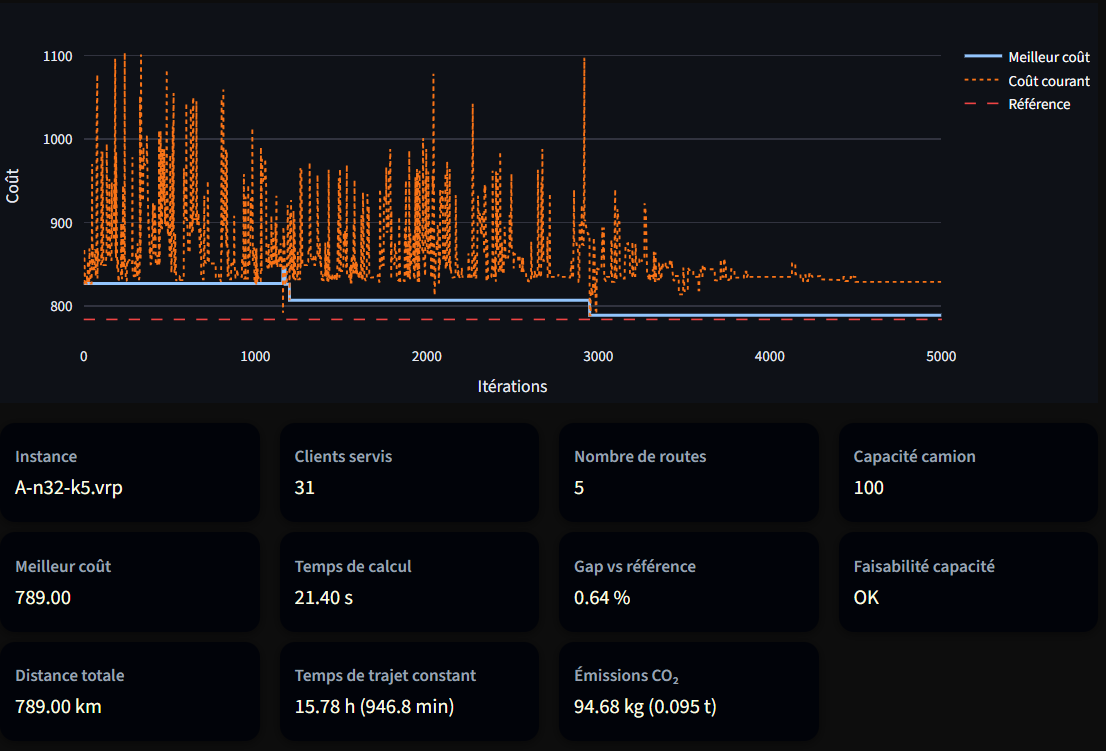

Analyse :

**Gap** très faible (0,64%) → solution proche de l’optimum connu.
**Temps de calcul** raisonnable (21 s) → bonne efficacité pour cette taille d’instance (32 clients).
**Faisabilité respectée** → toutes les contraintes de capacité et fenêtres de temps sont bien respectées.

###  Résultats sur l’instance A-n32-k5 (Multi-Run) 

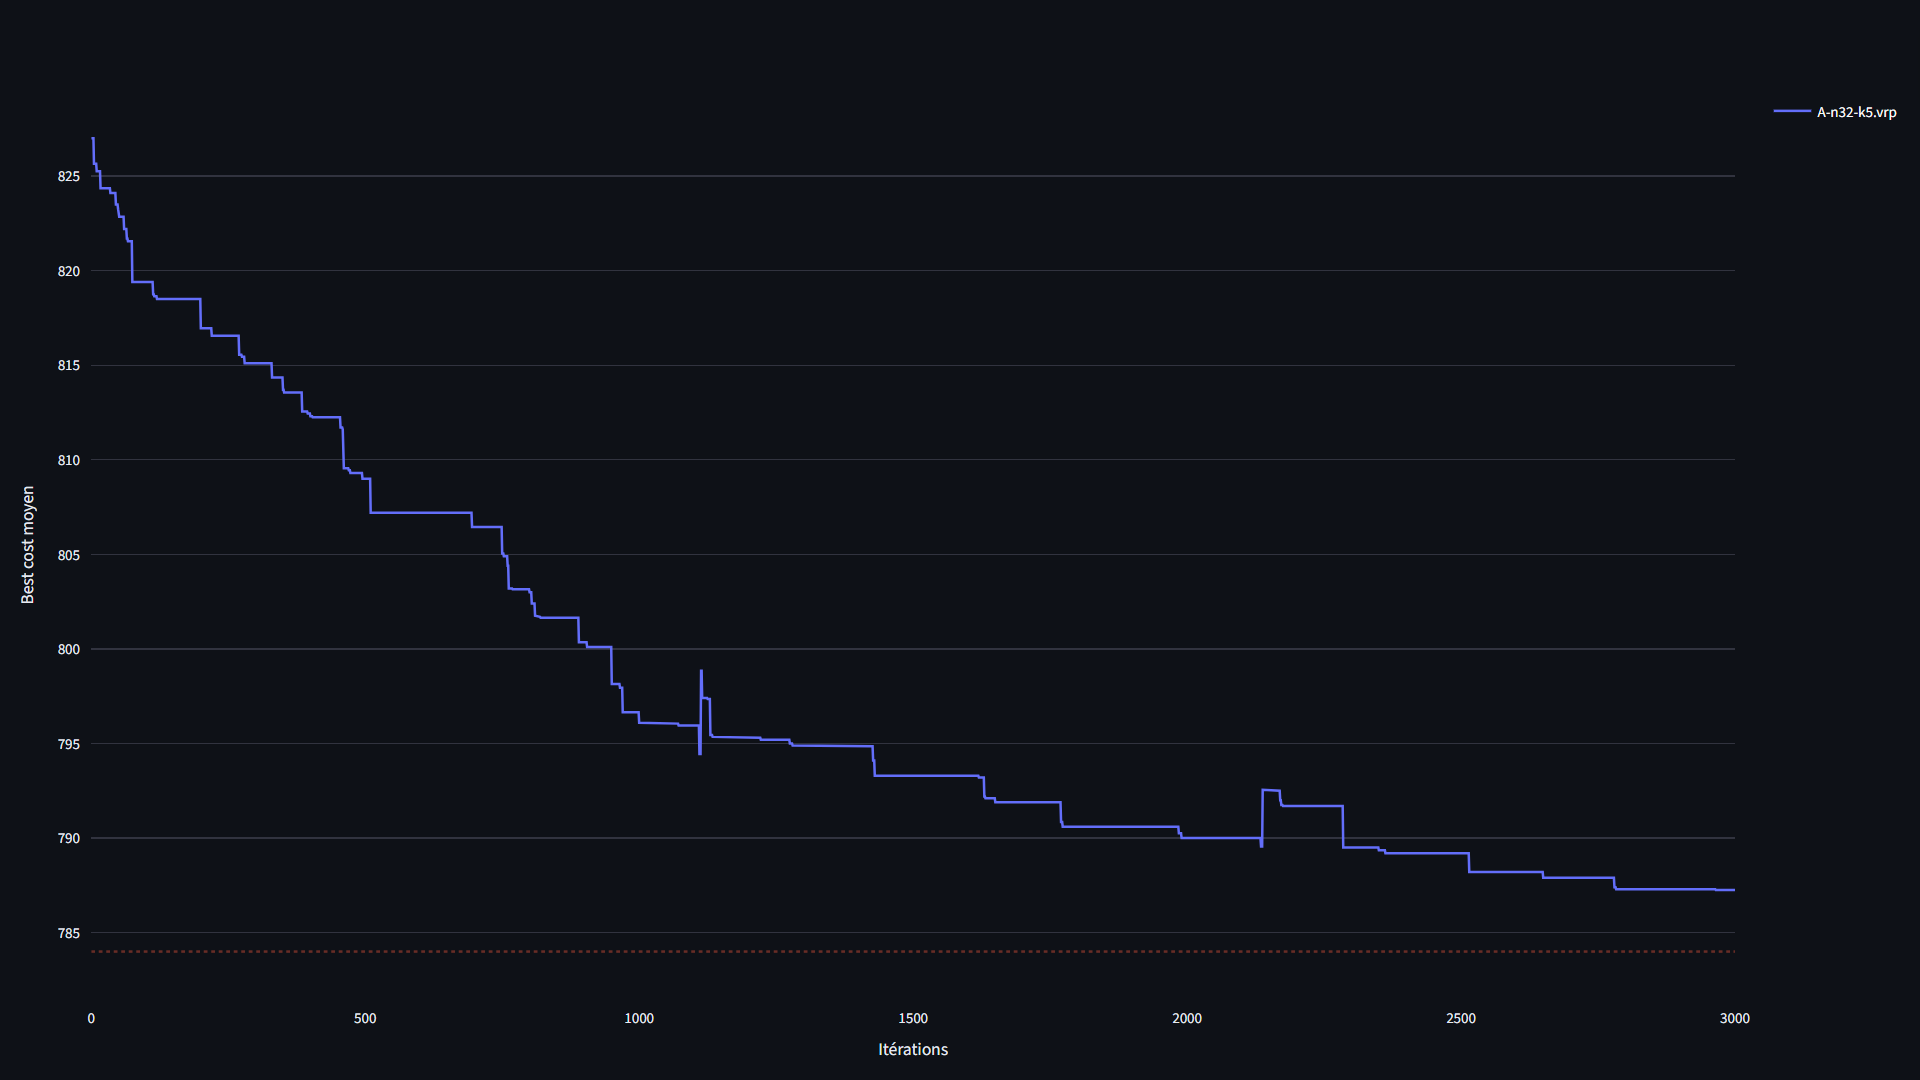

Analyse :

**Stabilité des résultats**
Les courbes de multi-run permettent d'évaluer la stabilité de l'algorithme. Les résultats sont proches les uns des autres (faible variance), cela indique que l'algorithme est robuste et produit des solutions de qualité constante.
Pour une petite instance comme A-n32-k5, on s'attend à une faible variance, car le problème est moins complexe et les solutions optimales sont plus accessibles.

**Le gap moyen** est faible (excellent résultat) : Comme indiqué dans le box plot suivant

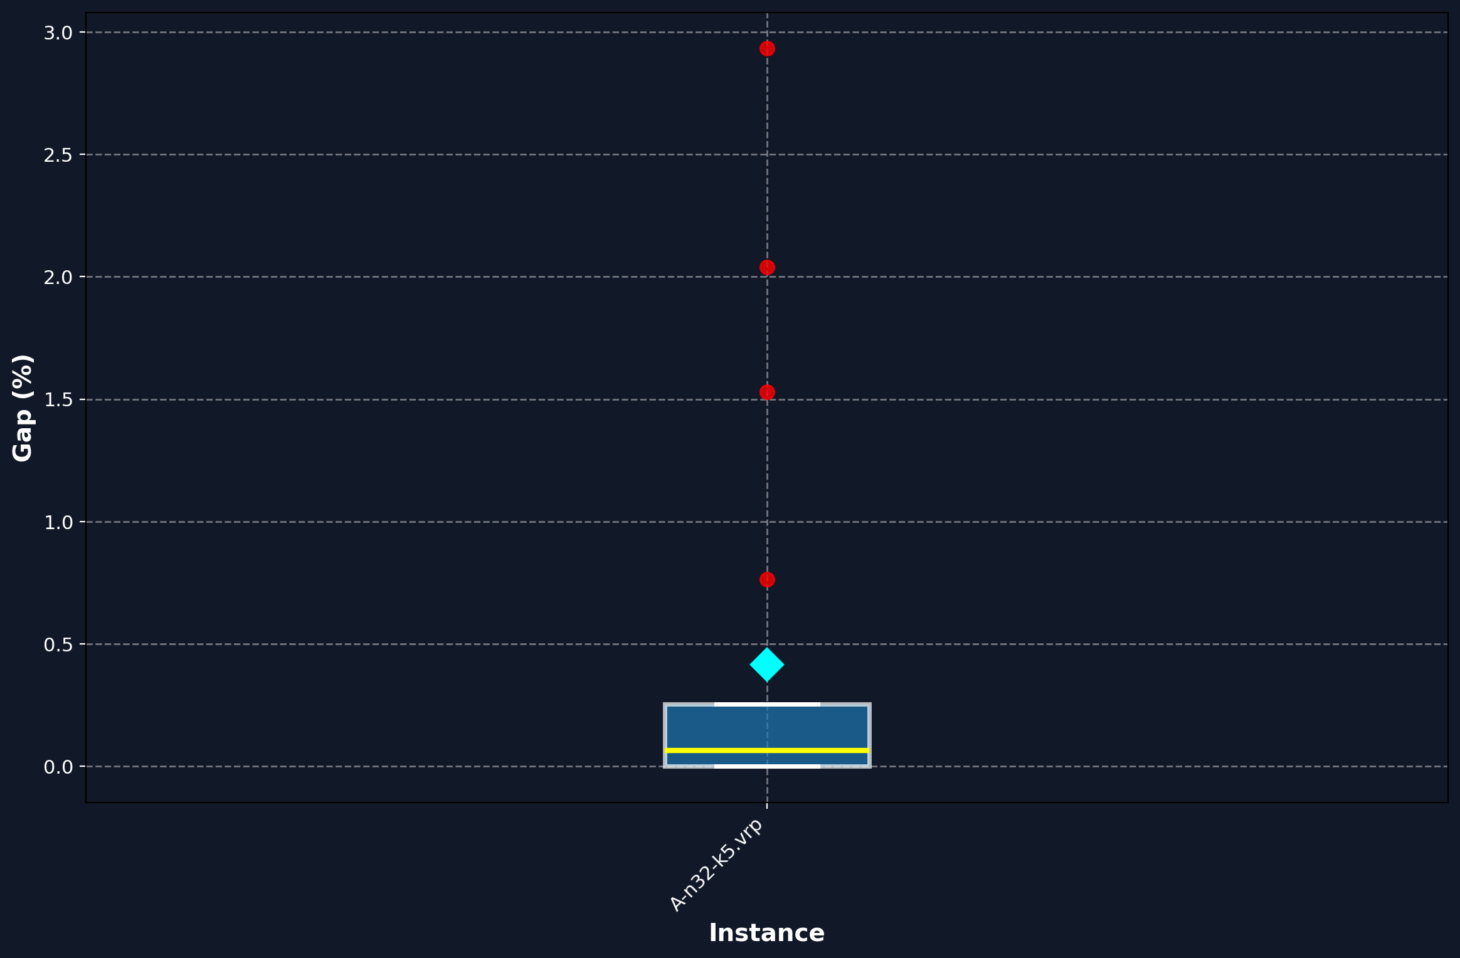

###  Résultats sur l’instance R202.txt (Single Run)
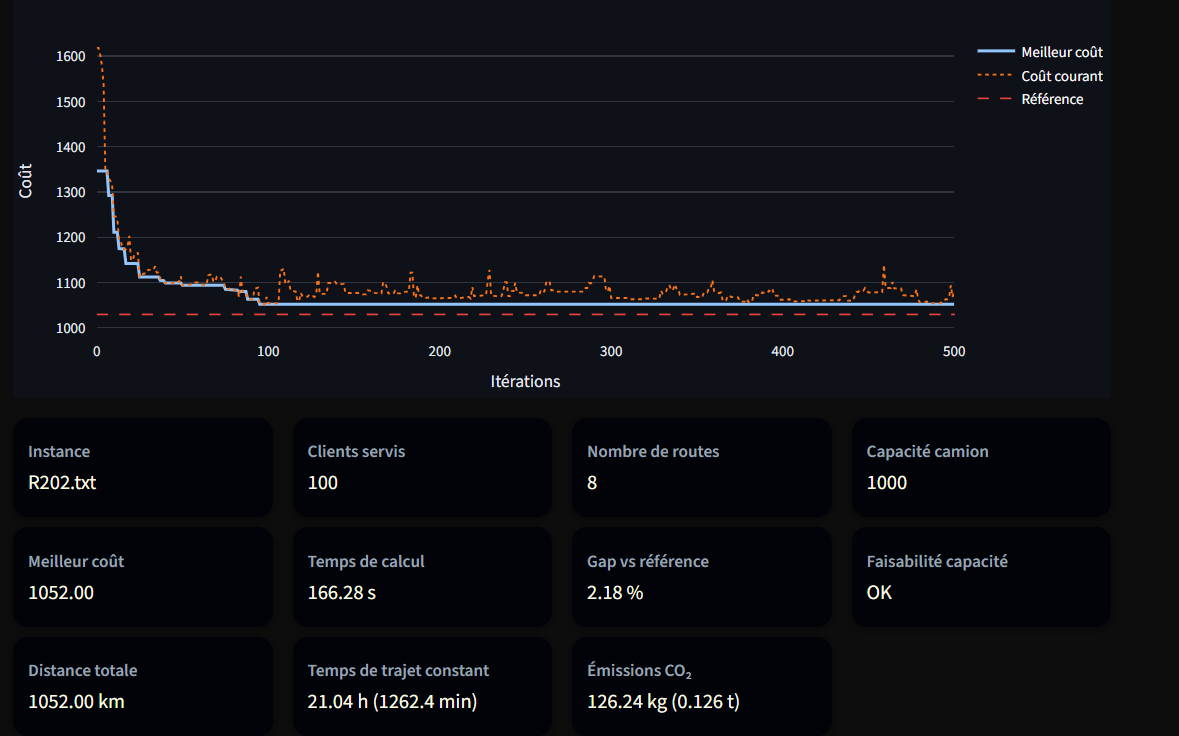

Analyse :

**Meilleur coût :** 1052.00, ce qui est un excellent résultat pour cette instance. Cela montre que l'algorithme parvient à minimiser efficacement le coût total.
Gap vs référence : 2.18%, ce qui indique que la solution obtenue est proche de l'optimum connu. Ce gap est acceptable pour une instance de taille moyenne comme R202.txt.

**Temps de calcul** : 166.28 secondes. Ce temps est raisonnable pour une instance avec 100 clients. Cela montre que l'algorithme est performant et adapté à des instances de taille moyenne.

**Faisabilité capacité :** OK. Cela confirme que toutes les contraintes de capacité des véhicules ont été respectées.

**Respect des fenêtres temporelles :** Les résultats ne mentionnent pas de violations, ce qui indique que l'algorithme gère correctement les contraintes temporelles.

**Nombre de routes :** 8. Cela montre que l'algorithme a trouvé une solution équilibrée en termes de répartition des clients entre les véhicules.

**Distance totale :** 1052.00 km. Cette distance est cohérente avec le coût total et reflète une optimisation efficace des trajets.

Covergence instance R202.txt (Multi-run)
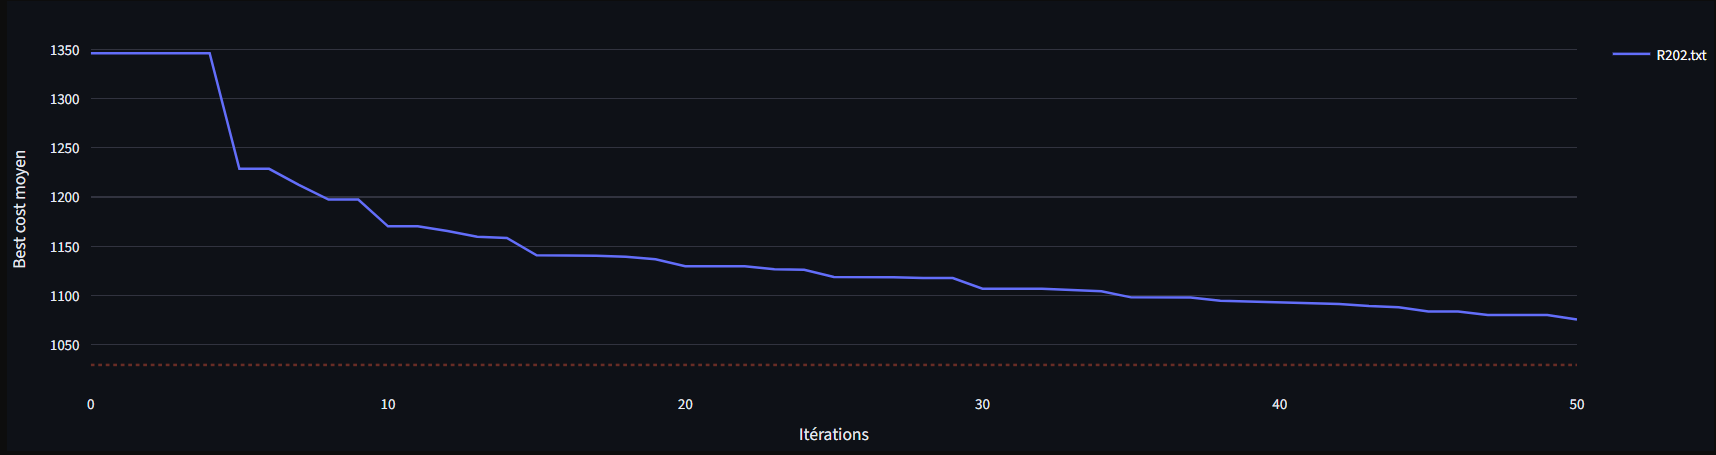

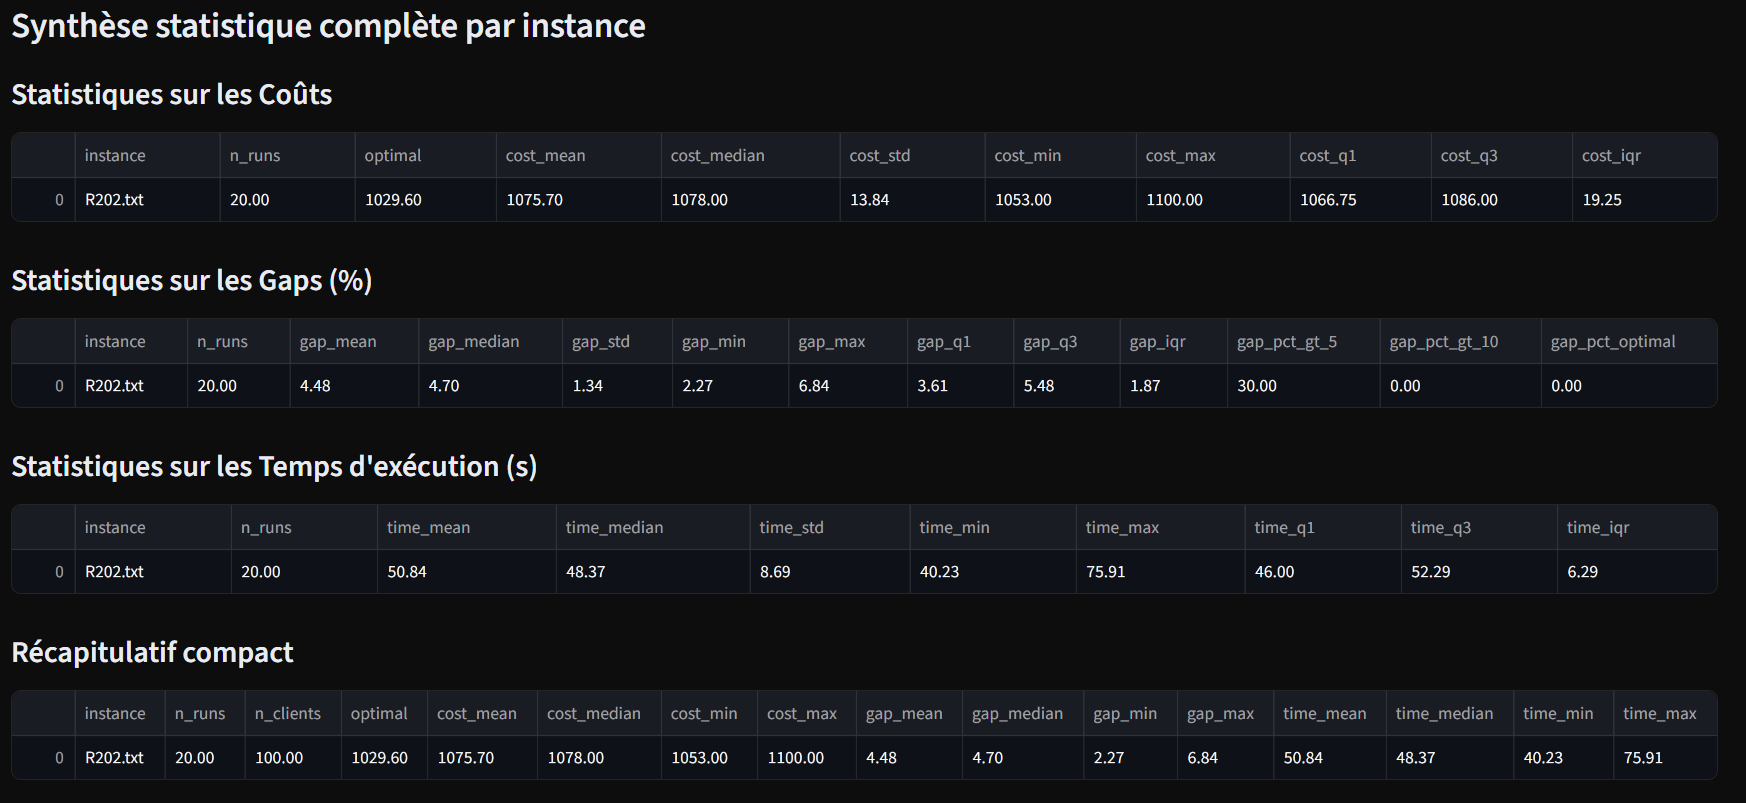

Histogramme des couts 
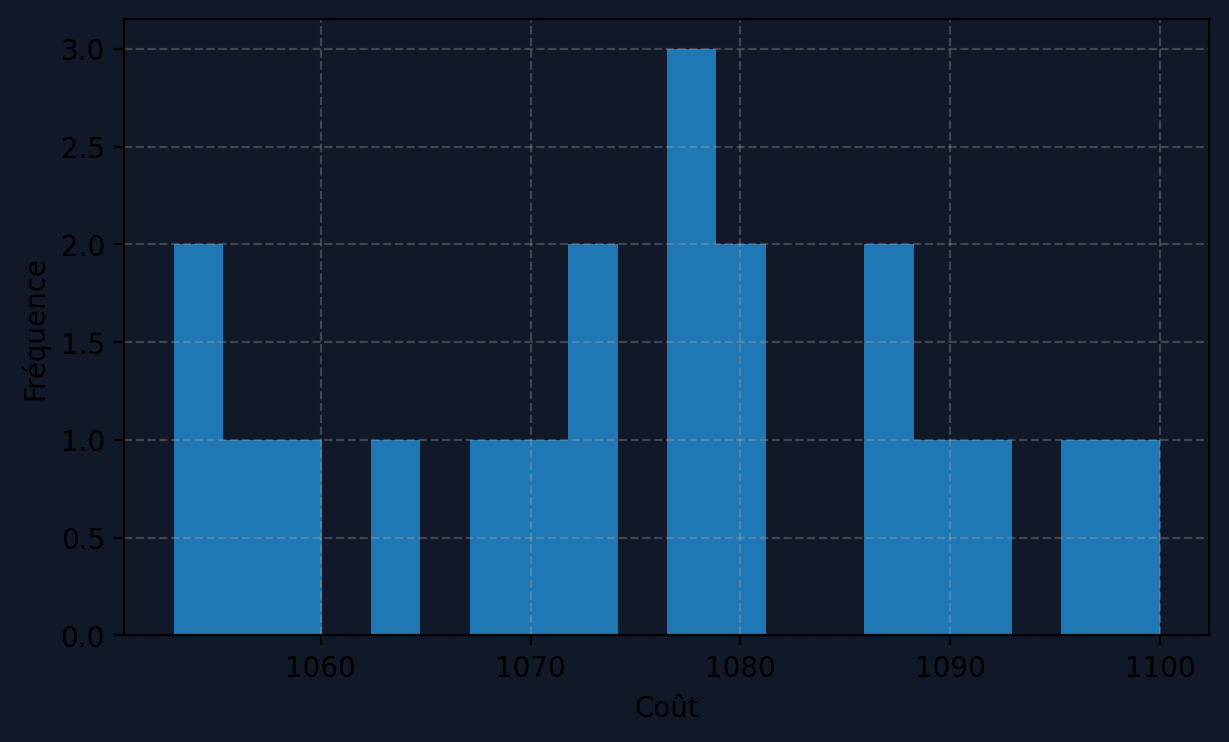
Avec un gap de :
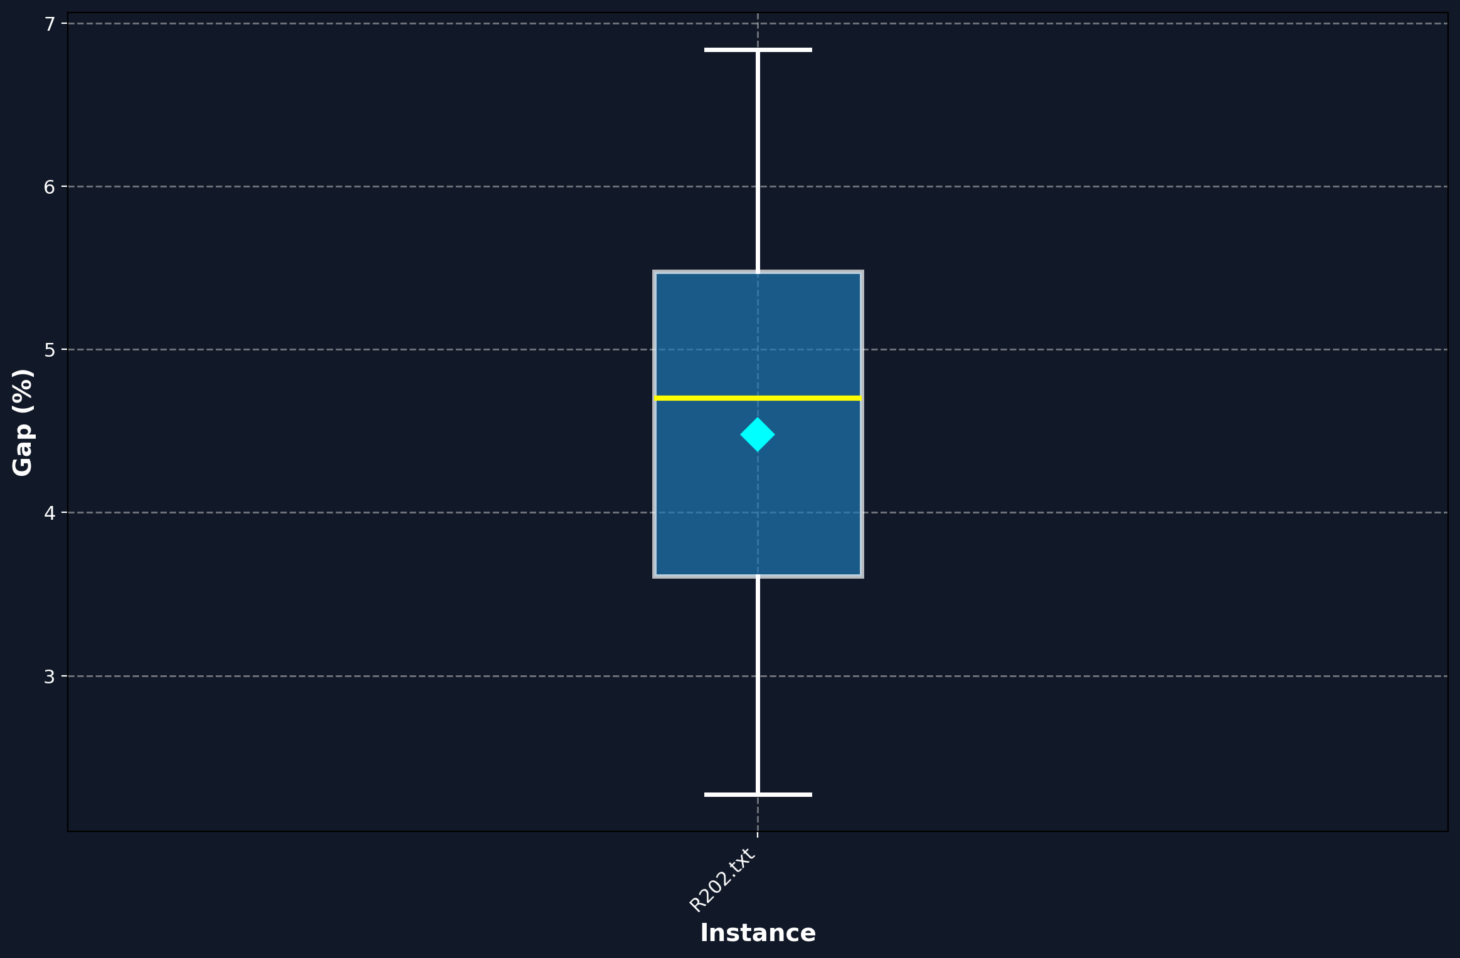
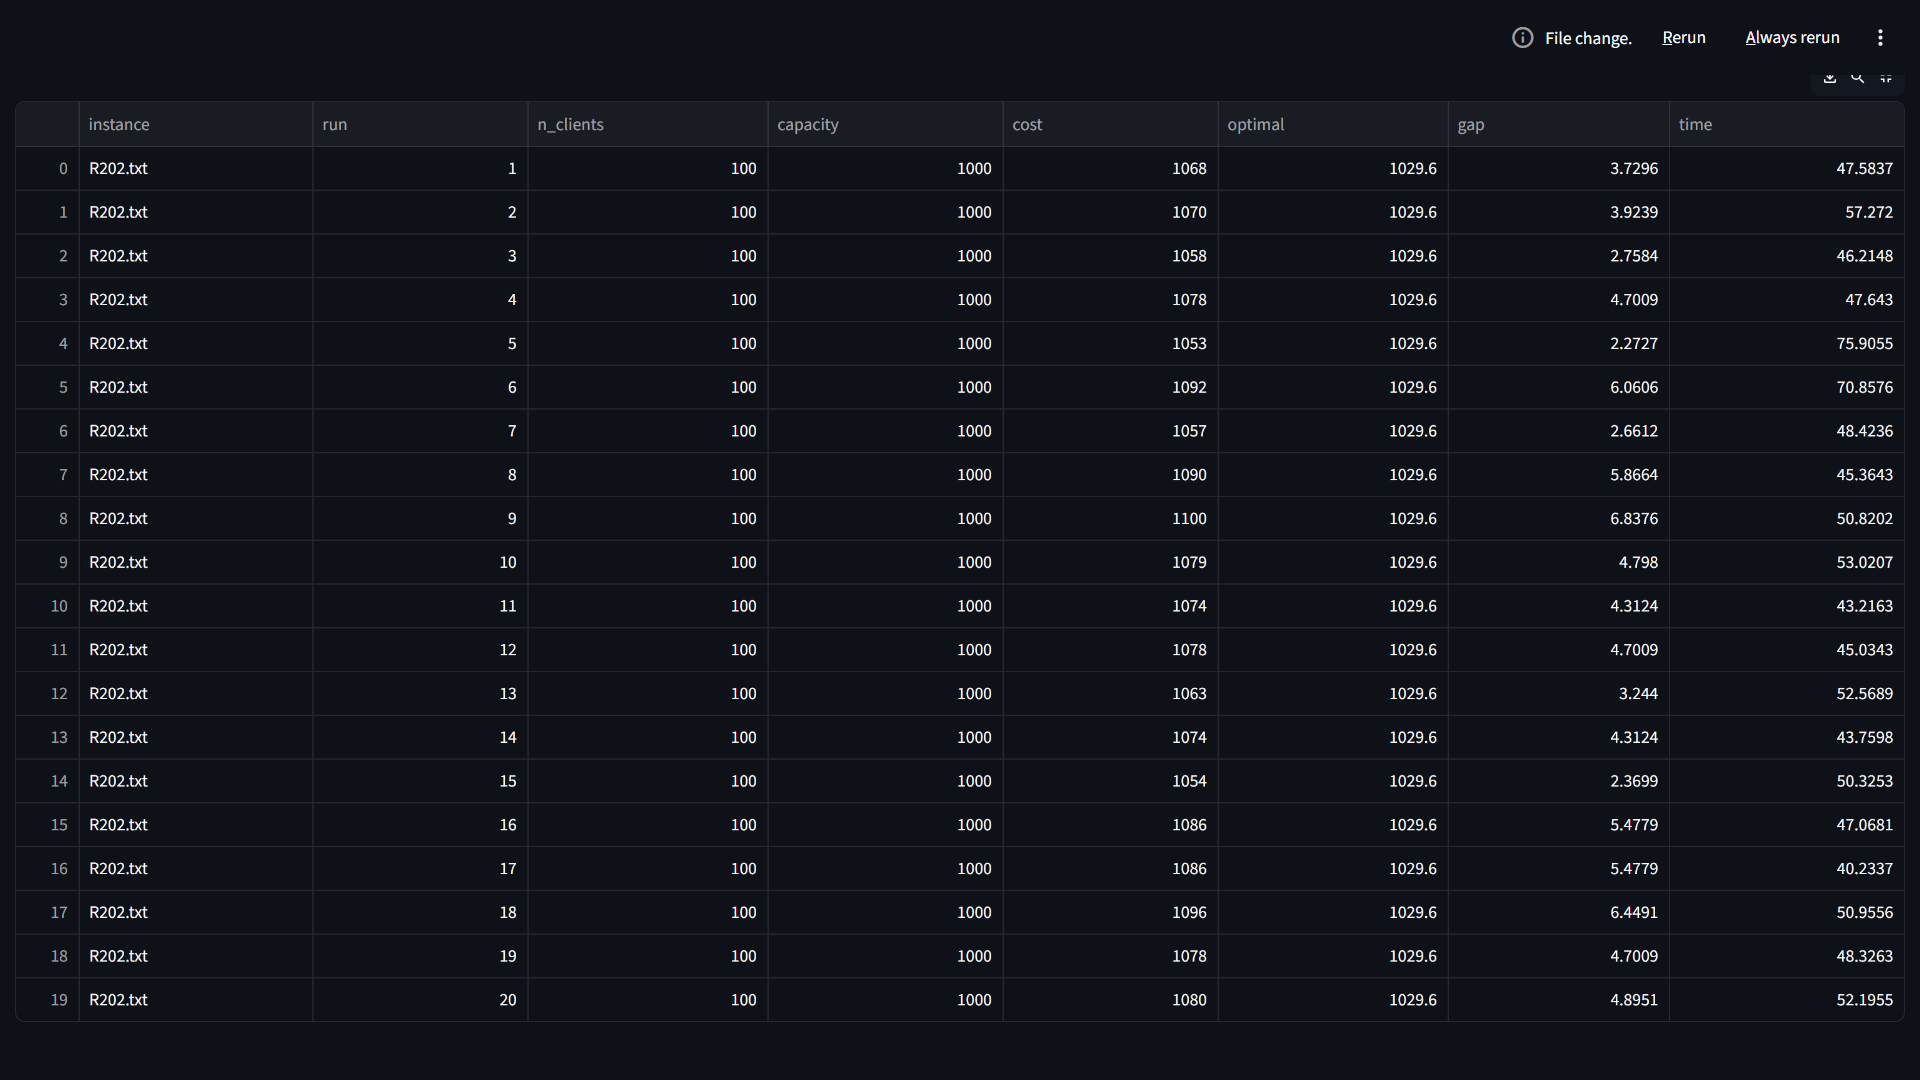

### Résultat de Single run d'une instance de 100 clients (X-n101-k25) :
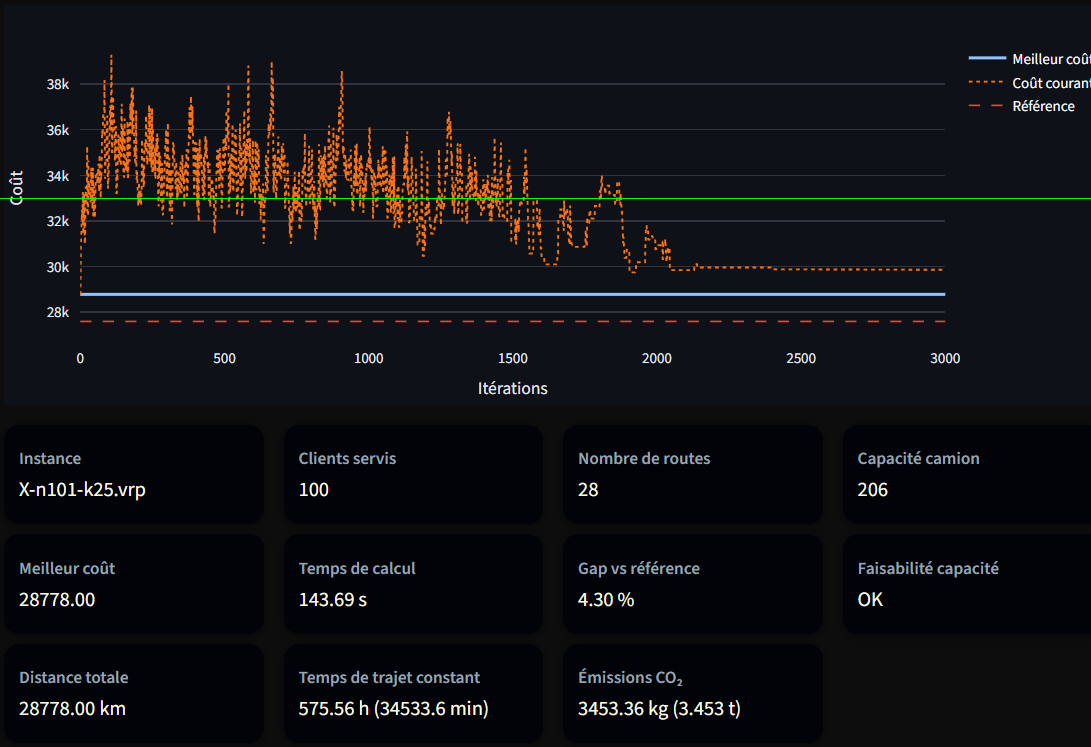

Schéma de routes :
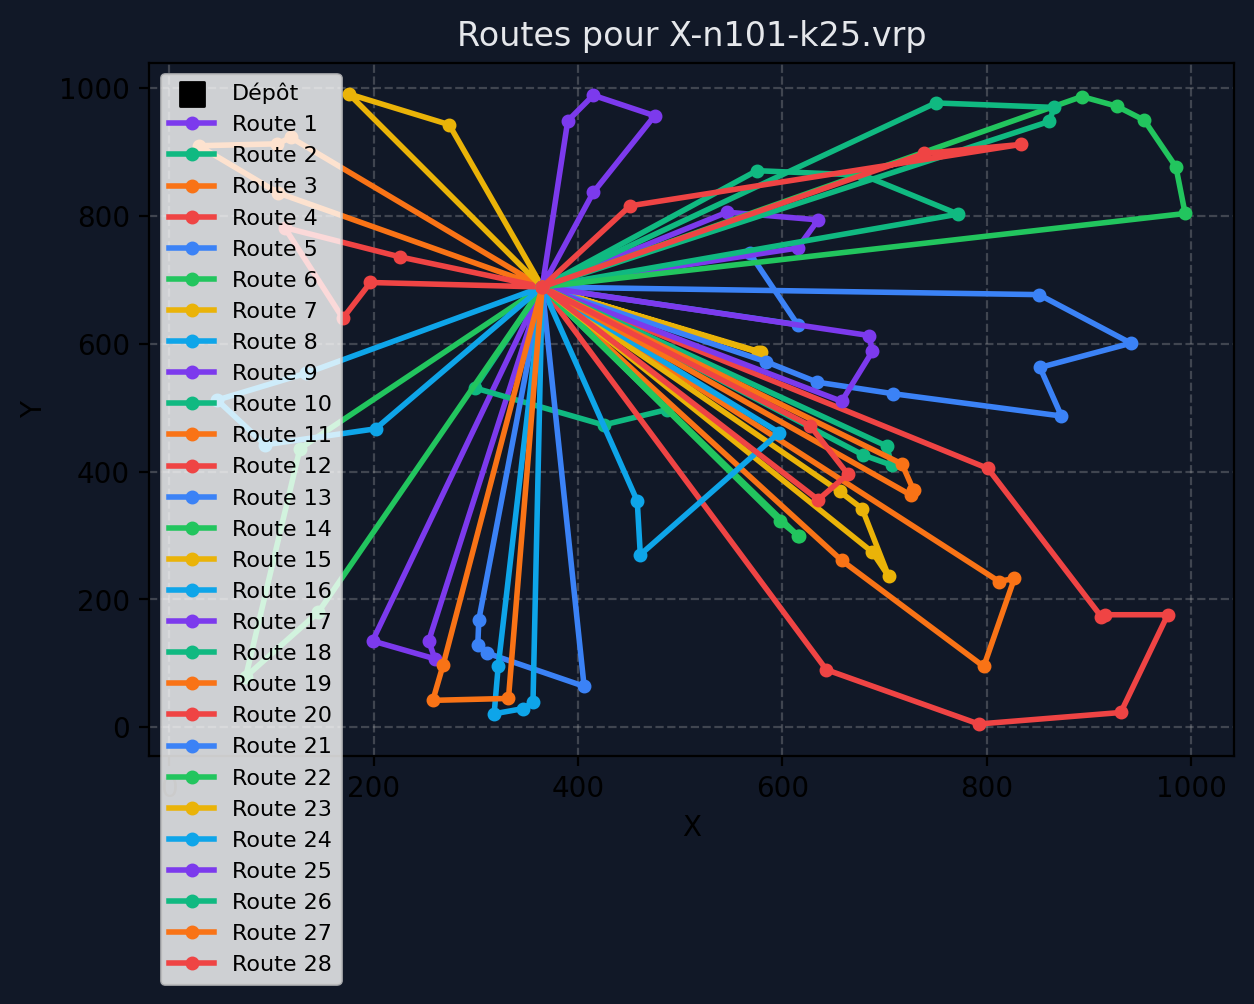

### Résultat de Single run d'une instance de 1000 clients : 
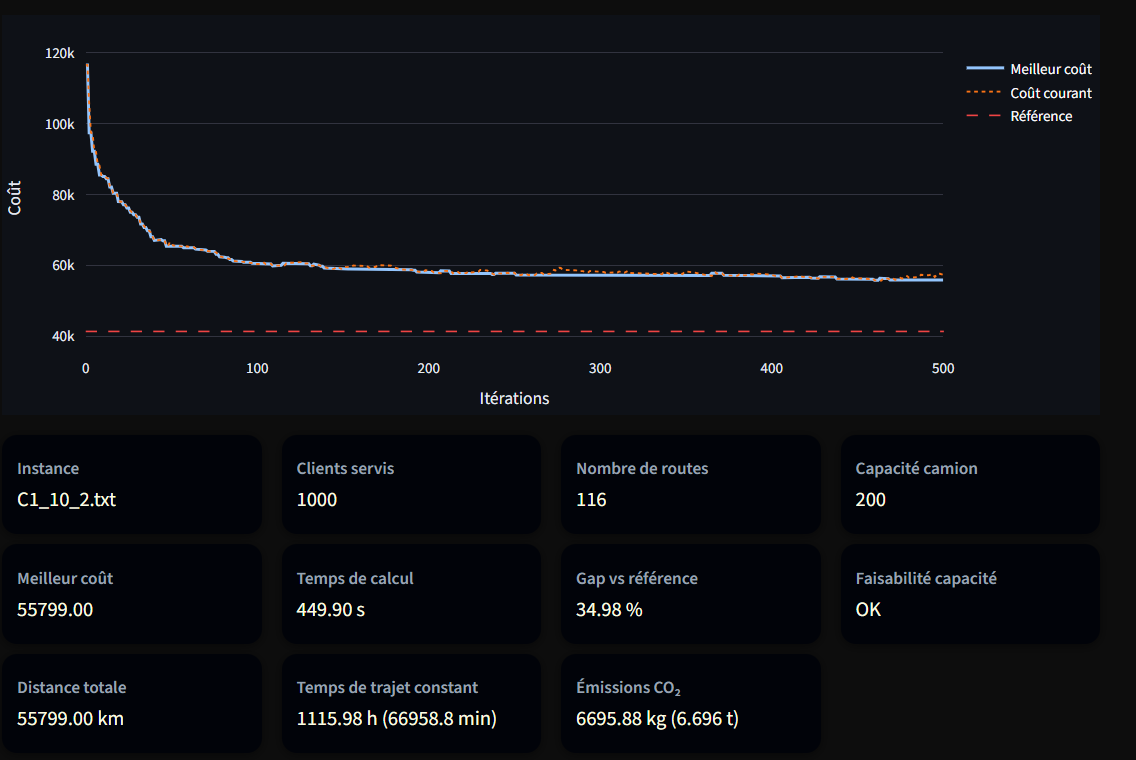
Qualité de la solution
Meilleur coût : 55,799.00, ce qui représente une solution optimisée pour cette instance complexe avec 1,000 clients. Cependant, le gap vs référence est élevé (34.98%) puisque c'est seulement 500 itérations. (on a déja essayé avec 100 itérations et on a eu le gap 49.79% donc -14.91% du gap)

# Conclusion

Dans le cadre de l'appel à manifestation d'intérêt de l'ADEME pour l'optimisation de la mobilité et de la logistique, notre équipe a développé une solution complète pour le problème de tournées de véhicules avec fenêtres temporelles et contraintes de capacité (CVRPTW).

Nous avons d'abord établi une **modélisation mathématique rigoureuse** du problème, en formalisant les variables de décision, la fonction objectif et l'ensemble des contraintes (couverture des clients, flot, capacité, fenêtres temporelles). Cette étape nous a permis de comprendre la complexité NP-difficile du problème et de justifier le recours à des métaheuristiques.

Notre **approche de résolution** combine pleusieurs méthode : Cette stratégie permet de traiter des instances de grande taille en obtenant des solutions de bonne qualité en un temps raisonnable.

L'**implémentation en Python** a été réalisée de manière modulaire et documentée, facilitant les tests et l'extension future du code. L'étude expérimentale valide la performance de notre algorithme sur des instances de référence.

Ce projet démontre que **l'optimisation par recherche opérationnelle constitue un levier efficace pour réduire l'empreinte carbone** du secteur logistique. En minimisant le temps parcourues tout en respectant les contraintes opérationnelles, notre solution contribue directement aux objectifs environnementaux de l'ADEME.

En conclusion, ce travail illustre comment une approche scientifique rigoureuse, alliant modélisation mathématique et algorithmes performants, peut apporter des réponses concrètes aux défis environnementaux et logistiques actuels.
